In [2]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from SyntheticControlMethods import DiffSynth, Synth

from dfmdash.dfm import ModelRunner
from dfmdash.results import parse_run_results

plt.style.use("ggplot")

FIG_OUT = Path("Paper_Figures")
FIG_OUT.mkdir(exist_ok=True)

# Data

Read in Factors

In [3]:
all_factors = pd.read_csv('./results/factors.csv')
all_factors.head()

,Time,Factor_Pandemic,Factor_Consumption,Factor_GDP,Factor_Cons3,Factor_Cons4,Factor_Cons5,Factor_Cons2,Factor_Cases5,Factor_Cases2,...,Factor_Deaths2,Factor_Cases3,Factor_Deaths3,Factor_Cases4,Factor_Cases1,Factor_Hosp2,Factor_Hosp1,Factor_Deaths4,Factor_Deaths1,State
0,2/1/2012,-1.161055,0.170095,294888.4089,22717.46446,43092.70514,135937.3315,65810.18635,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MN
1,3/1/2012,-1.171222,-0.025467,295976.4376,22726.87622,43088.33409,136033.2130,65815.23537,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MN
2,4/1/2012,-1.171824,-0.416690,296195.7022,22749.68458,43109.43331,136209.1536,65859.15126,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MN
3,5/1/2012,-1.171860,-2.142386,297136.4557,22827.90665,43235.54277,136716.8652,66063.49119,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MN
4,6/1/2012,-1.171862,-1.655460,297893.9661,22892.06050,43334.97152,137140.3855,66227.08216,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MN


In [4]:
def normalize(df, batch_col=None):
    time = df.index
    if batch_col:
        batch_column = df[batch_col].copy()
        df = df.drop(columns=[batch_col])
        df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns, index=time)
        df[batch_col] = batch_column
    else:
        df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns, index=time)
    return df

Read in normalized data

In [5]:
dfs = []
for subdir in Path('./results').iterdir():
    if subdir.is_dir():
        raw = pd.read_csv(subdir / 'df.csv')
        raw['State'] = subdir.name
        dfs.append(raw)

norm = pd.concat(dfs)
norm.head()

,Time,GDP,Cons3,Cons4,Cons5,Cons2,Cases5,Cases2,Deaths5,Deaths2,Cases3,Deaths3,Cases4,Cases1,Hosp2,Hosp1,Deaths4,Deaths1,State
0,2/1/2012,0.653034,0.343526,0.285676,0.599939,0.237297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MN
1,3/1/2012,0.658531,0.364740,0.309120,0.616711,0.266172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MN
2,4/1/2012,0.603592,0.403734,0.352081,0.647603,0.319136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MN
3,5/1/2012,0.648975,0.564603,0.528832,0.775285,0.537231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MN
4,6/1/2012,0.637306,0.523144,0.483472,0.742286,0.481186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MN


## Figure 1 - Pandemic

In [6]:
columns = [
    "Cases5",
    "Cases2",
    "Deaths5",
    "Deaths2",
    "Cases3",
    "Deaths3",
    "Cases4",
    "Cases1",
    "Hosp1",
    "Deaths4",
    "Deaths1",
]
factor = "Factor_Pandemic"
state = "MA"
time = datetime(2020, 1, 1)
invert = True
df = norm[norm.State == state].set_index("Time").drop(columns=["State"])[columns]
factors = all_factors[all_factors.State == state].set_index("Time")

if invert:
    factors[factor] = factors[factor] * -1

df = df.join(factors[[factor]]).rename(columns={factor: factor[7:]})
df.index = pd.DatetimeIndex(df.index)
df = df[df.index > time]
df = normalize(df)
df = df.melt(var_name="Metric", value_name="Normalized Value", ignore_index=False)
df['Label'] = ['Factor' if x == factor[7:] else 'Data' for x in df.Metric]
df = df.reset_index().sort_values(['Metric', 'Time'])
df.head()

,Time,Metric,Normalized Value,Label
245,2020-02-01,Cases1,0.000000,Data
246,2020-03-01,Cases1,0.033052,Data
247,2020-04-01,Cases1,0.138976,Data
248,2020-05-01,Cases1,0.072053,Data
249,2020-06-01,Cases1,0.016776,Data


### Theme 1

In [7]:
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.size": 14,
        "axes.labelsize": 14,
        "axes.titlesize": 20,
        "legend.fontsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
    }
)

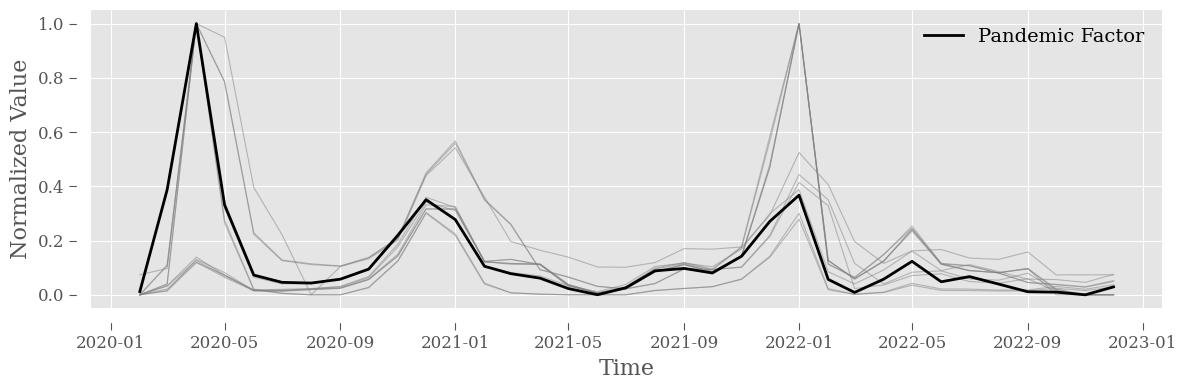

In [8]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the raw data with subtle colors
for metric, group in df[df['Label'] == 'Data'].reset_index().groupby('Metric'):
    ax.plot(group['Time'], group['Normalized Value'], color='gray', alpha=0.5, linewidth=0.8, label='_nolegend_')

# Plot the factor with a contrasting color and thicker line
factor_data = df[df['Label'] == 'Factor'].reset_index()
ax.plot(factor_data['Time'], factor_data['Normalized Value'], color='black', linewidth=2, label='Pandemic Factor')

# Customize the plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.tick_params(direction='out', length=6, width=0.8)
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.tick_params(axis='x', which='both', bottom=True, top=False)
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Normalized Value', fontsize=16)

# Minimalist legend placement
ax.legend(frameon=False, loc='upper right')

# Add labels
ax.set_xlabel('Time')
ax.set_ylabel('Normalized Value')

plt.tight_layout()
plt.show()

### Theme 2

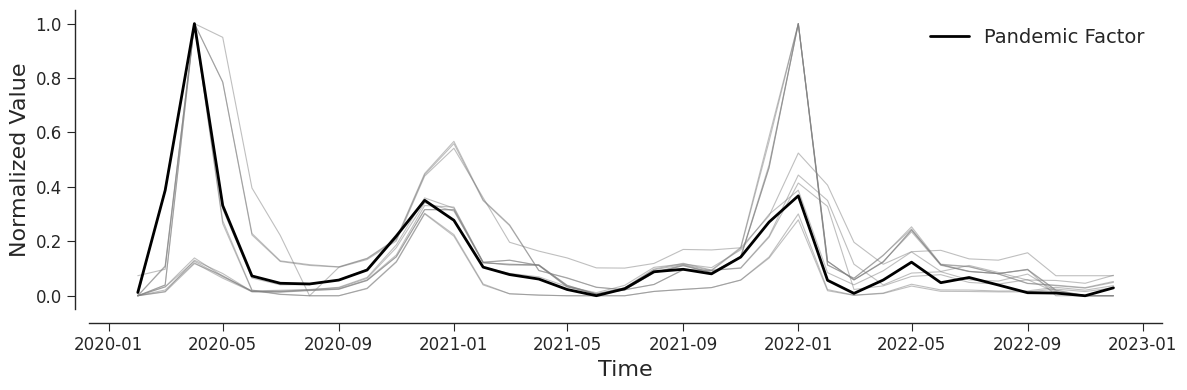

In [9]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the raw data with subtle colors
for metric, group in df[df['Label'] == 'Data'].reset_index().groupby('Metric'):
    ax.plot(group['Time'], group['Normalized Value'], color='gray', alpha=0.5, linewidth=0.8, label='_nolegend_')

# Plot the factor with a contrasting color and thicker line
factor_data = df[df['Label'] == 'Factor'].reset_index()
ax.plot(factor_data['Time'], factor_data['Normalized Value'], color='black', linewidth=2, label='Pandemic Factor')

# Customize the plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.tick_params(direction='out', length=6, width=0.8)
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.tick_params(axis='x', which='both', bottom=True, top=False)
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Normalized Value', fontsize=16)

# Minimalist legend placement
ax.legend(frameon=False, loc='upper right')

# Add labels
ax.set_xlabel('Time')
ax.set_ylabel('Normalized Value')

plt.tight_layout()
plt.savefig(FIG_OUT / "MA-Pandemic.png", dpi=600)

## Figure 2 - Consumption

In [10]:
columns = [
    "GDP",
    "Cons2",
    "Cons3",
    "Cons4",
    "Cons5",
]
factor = "Factor_Consumption"
state = "MA"
time = datetime(2020, 1, 1)
invert = True
df = norm[norm.State == state].set_index("Time").drop(columns=["State"])[columns]
factors = all_factors[all_factors.State == state].set_index("Time")

if invert:
    factors[factor] = factors[factor] * -1

df = df.join(factors[[factor]]).rename(columns={factor: factor[7:]})
df.index = pd.DatetimeIndex(df.index)
df = df[df.index > time]
df = normalize(df)
df = df.melt(var_name="Metric", value_name="Normalized Value", ignore_index=False)
df['Label'] = ['Factor' if x == factor[7:] else 'Data' for x in df.Metric]
df = df.reset_index().sort_values(['Metric', 'Time'])
df.head()

,Time,Metric,Normalized Value,Label
35,2020-02-01,Cons2,0.339886,Data
36,2020-03-01,Cons2,0.595546,Data
37,2020-04-01,Cons2,0.831451,Data
38,2020-05-01,Cons2,0.345702,Data
39,2020-06-01,Cons2,0.154480,Data


### Theme 1

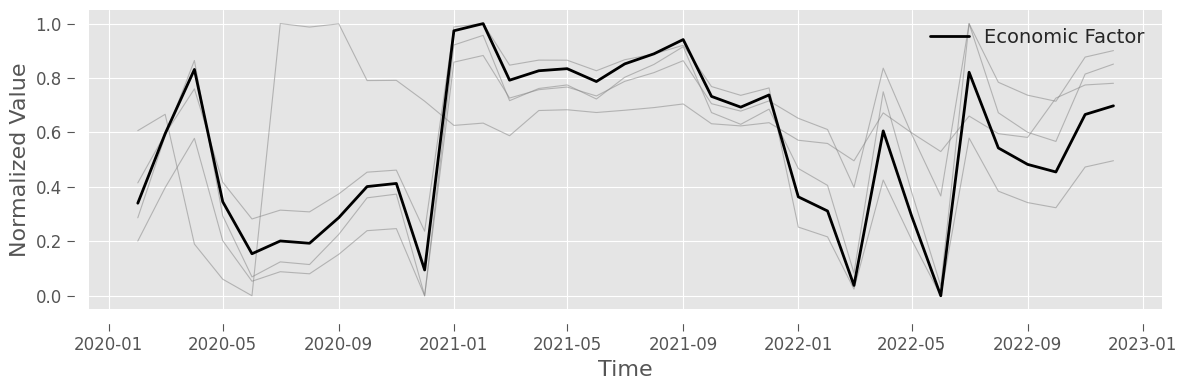

In [11]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the raw data with subtle colors
for metric, group in df[df['Label'] == 'Data'].reset_index().groupby('Metric'):
    ax.plot(group['Time'], group['Normalized Value'], color='gray', alpha=0.5, linewidth=0.8, label='_nolegend_')

# Plot the factor with a contrasting color and thicker line
factor_data = df[df['Label'] == 'Factor'].reset_index()
ax.plot(factor_data['Time'], factor_data['Normalized Value'], color='black', linewidth=2, label='Economic Factor')

# Customize the plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.tick_params(direction='out', length=6, width=0.8)
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.tick_params(axis='x', which='both', bottom=True, top=False)
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Normalized Value', fontsize=16)

# Minimalist legend placement
ax.legend(frameon=False, loc='upper right')

# Add labels
ax.set_xlabel('Time')
ax.set_ylabel('Normalized Value')

plt.tight_layout()
plt.show()

### Theme 2

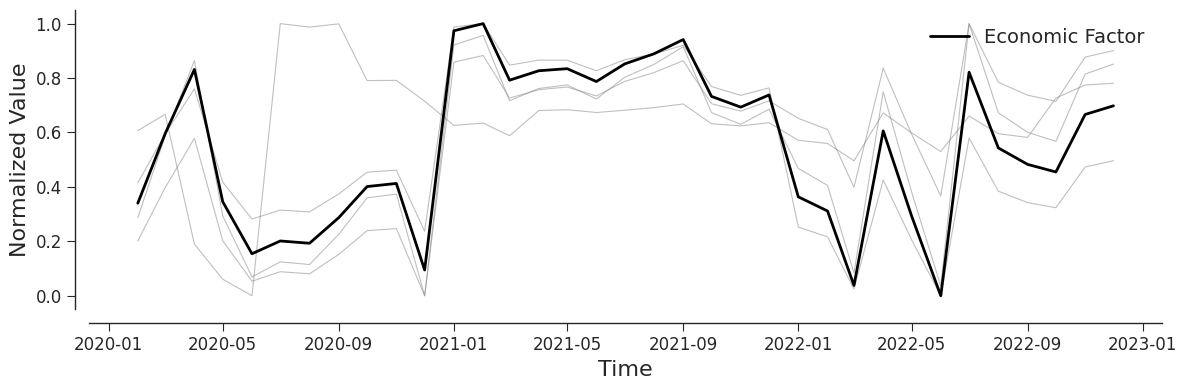

In [12]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the raw data with subtle colors
for metric, group in df[df['Label'] == 'Data'].reset_index().groupby('Metric'):
    ax.plot(group['Time'], group['Normalized Value'], color='gray', alpha=0.5, linewidth=0.8, label='_nolegend_')

# Plot the factor with a contrasting color and thicker line
factor_data = df[df['Label'] == 'Factor'].reset_index()
ax.plot(factor_data['Time'], factor_data['Normalized Value'], color='black', linewidth=2, label='Economic Factor')

# Customize the plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.tick_params(direction='out', length=6, width=0.8)
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.tick_params(axis='x', which='both', bottom=True, top=False)
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Normalized Value', fontsize=16)

# Minimalist legend placement
ax.legend(frameon=False, loc='upper right')

# Add labels
ax.set_xlabel('Time')
ax.set_ylabel('Normalized Value')

plt.tight_layout()
plt.savefig(FIG_OUT / "MA-Economic.png", dpi=600)

# SCM Figure

In [13]:
result_dir = Path("./results")
factors_path = result_dir / "factors.csv"

fdf = pd.read_csv(factors_path)
cols_to_drop = [x for x in fdf.columns if "Time." in x]
fdf = fdf.drop(columns=cols_to_drop)
fdf.columns = [x.lstrip("Factor_") for x in fdf.columns]

# Process Data
dfs = []
for subdir in result_dir.iterdir():
    if not subdir.is_dir():
        continue
    state = pd.read_csv(subdir / "df.csv")
    state["State"] = subdir.stem
    dfs.append(state)
df = pd.concat(dfs)
df = df.set_index(["Time", "State"])
columns = [x for x in fdf.columns if x not in df.columns]
min_time = pd.to_datetime(fdf["Time"]).min()
max_time = pd.to_datetime(fdf["Time"].max())
states = sorted(fdf.State.unique())
fdf = fdf[columns].set_index(["Time", "State"])
df = df.join(fdf)
df.head()

,,GDP,Cons3,Cons4,Cons5,Cons2,Cases5,Cases2,Deaths5,Deaths2,Cases3,Deaths3,Cases4,Cases1,Hosp2,Hosp1,Deaths4,Deaths1,Pandemic,Consumption
Time,State,,,,,,,,,,,,,,,,,,,
2/1/2012,MN,0.653034,0.343526,0.285676,0.599939,0.237297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.161055,0.170095
3/1/2012,MN,0.658531,0.364740,0.309120,0.616711,0.266172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.171222,-0.025467
4/1/2012,MN,0.603592,0.403734,0.352081,0.647603,0.319136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.171824,-0.416690
5/1/2012,MN,0.648975,0.564603,0.528832,0.775285,0.537231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.171860,-2.142386
6/1/2012,MN,0.637306,0.523144,0.483472,0.742286,0.481186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.171862,-1.655460


In [14]:
# Select Variables
treated_unit = 'MA'
predictor_vars = ['Consumption']
outcome_var = 'Pandemic'
treatment_time = datetime(2022, 2, 1)

invert = True


df = df[[*predictor_vars, outcome_var]].reset_index()
sc = Synth(df, outcome_var, "State", "Time", str(treatment_time), treated_unit, n_optim=10, pen="auto")


sc.original_data.weight_df

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  4.12456D+01    |proj g|=  5.00000D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     17      3     0     3   5.000D-01   4.125D+01
  F =   41.245615368651137     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.3


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    3    f=  4.12456D+01    |proj g|=  5.56677D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4     40     10     1     3   1.000D+00   4.125D+01
  F =   41.245615251205507     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


,Weight
MN,0.058439
IL,0.098993
VA,0.161583
RI,0.102443
CT,0.214926
PA,0.057350
NJ,0.078189
NY,0.108720
MI,0.058789
ME,0.060567


In [15]:
sc.original_data.comparison_df

,MA,Synthetic MA,WMAPE,Importance
Consumption,-0.15,-0.14,0.10,1.0
Pandemic,-0.23,-0.10,0.31,0.0


In [16]:
data = sc.original_data
synth = data.synth_outcome
treated_outcome_all = data.treated_outcome_all
treatment_period = data.treatment_period
treated_label = "Treated"
synth_label = "Synthetic Control"
treatment_label = "Treatment"

# Determine appropriate limits for y-axis
max_value = max(np.max(treated_outcome_all), np.max(synth))
min_value = min(np.min(treated_outcome_all), np.min(synth))

# Create x/y
x = df[df.State == treated_unit].Time
ys = synth[0, :]
y = df[df.State == treated_unit][outcome_var]

if invert:
    y *= -1
    ys *= -1

# fig.add_trace(go.Scatter(x=x, y=y, mode="lines", name=f"{treated_unit} {outcome_var}"))
# fig.add_trace(go.Scatter(x=x, y=ys, mode="lines", name=f"Synthetic {outcome_var}", line=dict(dash="dot")))

In [17]:
x = pd.to_datetime(x)
x.max()

Timestamp('2022-12-01 00:00:00')

## Original

(-1.0, 12.0)

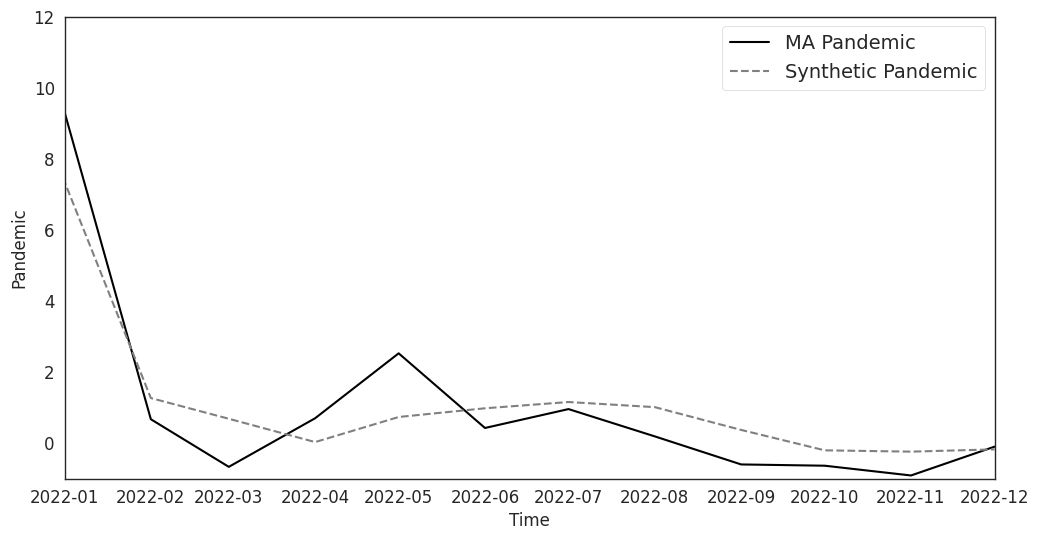

In [18]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=x, y=y, label=f"{treated_unit} {outcome_var}", c='black')
sns.lineplot(x=x, y=ys, label=f"Synthetic {outcome_var}", c='grey', linestyle='--')
plt.xlim([datetime(2022, 1,1), x.max()])
plt.ylim([-1, 12])
plt.savefig(FIG_OUT / "MA-Pandemic-Synth.png", dpi=600)

## Pointwise

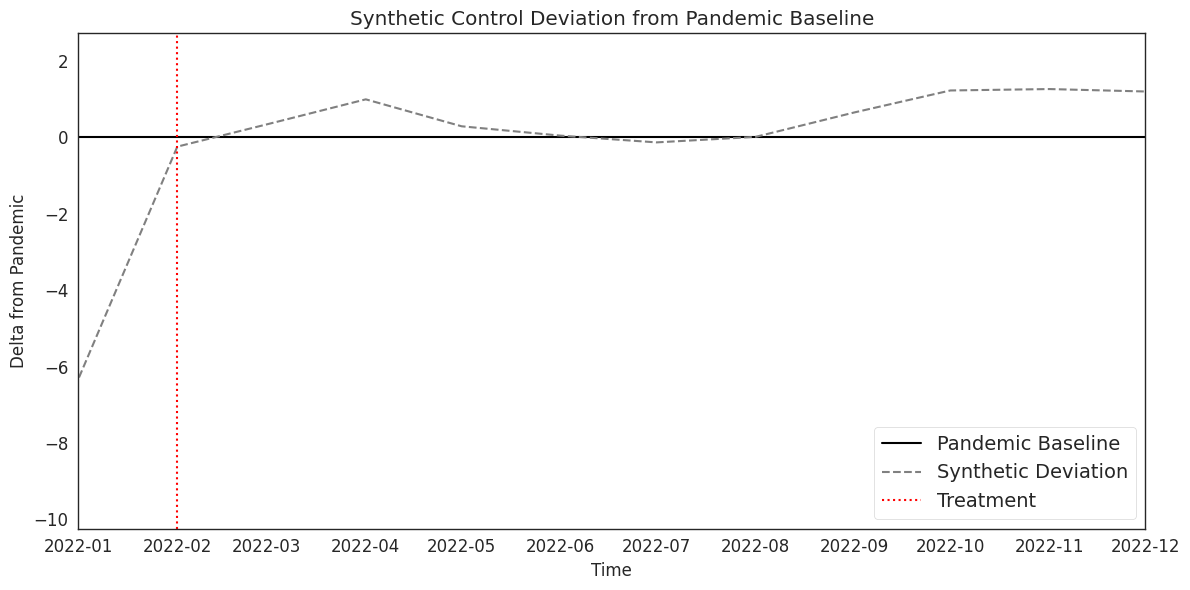

In [19]:
data = sc.original_data
synth = data.synth_outcome
treated_outcome_all = data.treated_outcome_all
treatment_period = data.treatment_period
treated_label = "Treated"
synth_label = "Synthetic Control"
treatment_label = "Treatment"

# Compute the delta from the pandemic data (treated outcome)
synth_delta = synth[0, :] - treated_outcome_all[0, :]

# Create x-axis data
x = df[df.State == treated_unit].Time
x = pd.to_datetime(x)
y = np.zeros_like(synth_delta)  # Pandemic as a flat line (zero)

# If inversion is needed
if invert:
    synth_delta *= -1

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x=x, y=y, label="Pandemic Baseline", color='black')  # Flat line at zero
sns.lineplot(x=x, y=synth_delta, label="Synthetic Deviation", color='grey', linestyle='--')

# Mark the treatment period
plt.axvline(x=pd.to_datetime(treatment_period), color='red', linestyle=':', label=treatment_label)

# Configure plot limits and labels
plt.xlim([datetime(2022, 1, 1), x.max()])
plt.ylim([min(synth_delta) - 1, max(synth_delta) + 1])
plt.xlabel("Time")
plt.ylabel("Delta from Pandemic")
plt.title("Synthetic Control Deviation from Pandemic Baseline")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_OUT / "MA-Pandemic-Delta.png", dpi=600)

# Dashboard Figures

## Dynamic Factor Model Runner

![](imgs/1.png)

## Factor Analysis

![](imgs/2.png)

## Comparative Run Analysis

![](imgs/3.png)